#Data Loading and Inspection

In [2]:
import pandas as pd

# your public Google Sheet (CSV format)
DATA_URL = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vRE_tDA08-ZCUw_MTzpR81QAB7onbf0QnZ92-XgwwST02xYyJkmba18aEHUy7kCeRwLXBehk14DYYQp/pub?output=csv'

# Load the data into a DataFrame
try:
    df = pd.read_csv(DATA_URL)
    print("Data successfully loaded!")

    # Display the first 5 rows
    print("\n--- DataFrame Head ---")
    print(df.head())

    # Display column names and their data types
    print("\n--- DataFrame Info ---")
    df.info()

except Exception as e:
    print(f"Error loading data: {e}")

Data successfully loaded!

--- DataFrame Head ---
      Model  Year         Region  Color Fuel_Type Transmission  Engine_Size_L  \
0  5 Series  2016           Asia    Red    Petrol       Manual            3.5   
1        i8  2013  North America    Red    Hybrid    Automatic            1.6   
2  5 Series  2022  North America   Blue    Petrol    Automatic            4.5   
3        X3  2024    Middle East   Blue    Petrol    Automatic            1.7   
4  7 Series  2020  South America  Black    Diesel       Manual            2.1   

   Mileage_KM  Price_USD  Sales_Volume Sales_Classification  
0      151748      98740          8300                 High  
1      121671      79219          3428                  Low  
2       10991     113265          6994                  Low  
3       27255      60971          4047                  Low  
4      122131      49898          3080                  Low  

--- DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 

#Data Preprocessing for Time-Series

In [3]:
# 1. Group by Year and sum the Sales_Volume
time_series_data = df.groupby('Year')['Sales_Volume'].sum().reset_index()

# 2. Rename the aggregated column for clarity
time_series_data.rename(columns={'Sales_Volume': 'Total_Sales_Volume'}, inplace=True)

# 3. Convert the 'Year' column to a proper datetime index (setting it to the start of the year)
time_series_data['Year'] = pd.to_datetime(time_series_data['Year'], format='%Y')

# 4. Set the 'Year' column as the DataFrame index
time_series_data.set_index('Year', inplace=True)

# Display the resulting time series data
print("✅ Time-Series Data Aggregation Complete!")
print("\n--- Aggregated Annual Sales Volume ---")
print(time_series_data)

✅ Time-Series Data Aggregation Complete!

--- Aggregated Annual Sales Volume ---
            Total_Sales_Volume
Year                          
2010-01-01            16933445
2011-01-01            16758941
2012-01-01            16751895
2013-01-01            16866733
2014-01-01            16958960
2015-01-01            17010207
2016-01-01            16957550
2017-01-01            16620811
2018-01-01            16412273
2019-01-01            17191956
2020-01-01            16310843
2021-01-01            16884666
2022-01-01            17920946
2023-01-01            16268654
2024-01-01            17527854


#Exploratory Data Analysis (EDA)

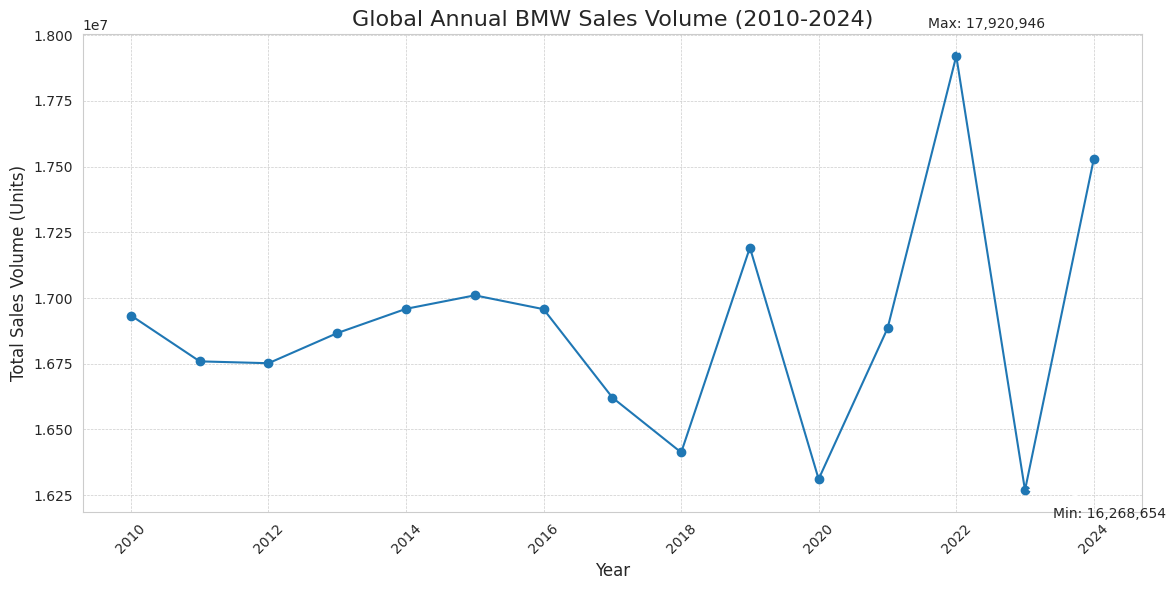


--- Sales Volume Descriptive Statistics ---
count    1.500000e+01
mean     1.689172e+07
std      4.346998e+05
min      1.626865e+07
25%      1.668635e+07
50%      1.688467e+07
75%      1.698458e+07
max      1.792095e+07
Name: Total_Sales_Volume, dtype: float64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# Create the plot
plt.figure(figsize=(12, 6))

# Plot the time series data
# time_series_data is the DataFrame from the previous step
plt.plot(time_series_data.index, time_series_data['Total_Sales_Volume'],
         marker='o', linestyle='-', color='tab:blue')

# Add titles and labels
plt.title('Global Annual BMW Sales Volume (2010-2024)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Sales Volume (Units)', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add annotations for max and min points for quick insight
max_sales_year = time_series_data['Total_Sales_Volume'].idxmax().year
max_sales_val = time_series_data['Total_Sales_Volume'].max()

min_sales_year = time_series_data['Total_Sales_Volume'].idxmin().year
min_sales_val = time_series_data['Total_Sales_Volume'].min()

plt.annotate(f'Max: {max_sales_val:,}',
             xy=(pd.to_datetime(str(max_sales_year)), max_sales_val),
             xytext=(-20, 20), textcoords='offset points',
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))

plt.annotate(f'Min: {min_sales_val:,}',
             xy=(pd.to_datetime(str(min_sales_year)), min_sales_val),
             xytext=(20, -20), textcoords='offset points',
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))


# Ensure layout is tight and display the plot
plt.tight_layout()
plt.show()

# Display a brief statistical summary
print("\n--- Sales Volume Descriptive Statistics ---")
print(time_series_data['Total_Sales_Volume'].describe())

#Time-Series Modeling using the ARIMA (Autoregressive Integrated Moving Average) model.

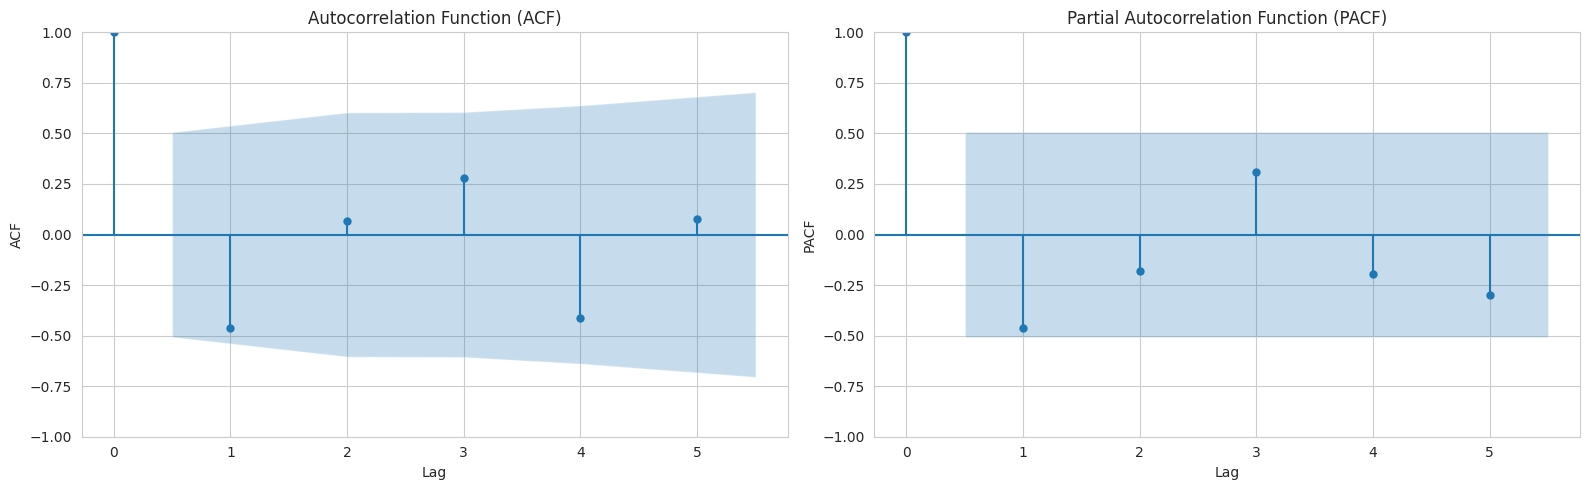


--- ADF Test Results ---
ADF Statistic: -1.648631
p-value: 0.457755
Critical Values:
	1%: -4.473
	5%: -3.290
	10%: -2.772


In [ ]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Ensure the time_series_data DataFrame is available from Step 2

# 1. Plot ACF and PACF to help determine p and q
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# ACF Plot
plot_acf(time_series_data['Total_Sales_Volume'], lags=5, ax=axes[0], title='Autocorrelation Function (ACF)')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('ACF')

# PACF Plot
plot_pacf(time_series_data['Total_Sales_Volume'], lags=5, ax=axes[1], title='Partial Autocorrelation Function (PACF)', method='ywm')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('PACF')

plt.tight_layout()
plt.show()

# 2. Statistical Stationarity Test (Augmented Dickey-Fuller Test)
# This confirms the visual assessment.
from statsmodels.tsa.stattools import adfuller

result = adfuller(time_series_data['Total_Sales_Volume'])
print("\n--- ADF Test Results ---")
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

#Model Fitting and Forecasting

In [5]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

# Define the ARIMA order
arima_order = (1, 1, 1)

# 1. Fit the ARIMA Model
# We are using the time_series_data['Total_Sales_Volume'] from previous steps
print("Fitting ARIMA(1, 1, 1) model...")
try:
    # Use the ARIMA model class from statsmodels
    model = ARIMA(time_series_data['Total_Sales_Volume'], order=arima_order)
    model_fit = model.fit()
    print("Model fitted successfully.")

    # Display the model summary (details on coefficients, etc.)
    print("\n--- Model Summary ---")
    print(model_fit.summary())

    # 2. Forecasting
    # Determine the number of steps to forecast (e.g., 3 years: 2025, 2026, 2027)
    steps_to_forecast = 3

    # Get the forecasted values and confidence intervals
    forecast_results = model_fit.get_forecast(steps=steps_to_forecast)
    forecast_values = forecast_results.predicted_mean
    confidence_intervals = forecast_results.conf_int()

    # Create an index for the forecasted years (start year is 2025)
    last_year = time_series_data.index.max().year
    forecast_years = [pd.to_datetime(f'{last_year + i}-01-01') for i in range(1, steps_to_forecast + 1)]

    # Combine results into a clean DataFrame
    forecast_df = pd.DataFrame({
        'Forecasted_Sales': forecast_values,
        'Lower_CI': confidence_intervals['lower Total_Sales_Volume'],
        'Upper_CI': confidence_intervals['upper Total_Sales_Volume']
    }, index=forecast_years)

    print("\n--- Sales Forecast (2025-2027) ---")
    print(forecast_df.round(0).astype(int))

except Exception as e:
    print(f" Error during model fitting or forecasting: {e}")

Fitting ARIMA(1, 1, 1) model...


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


Model fitted successfully.

--- Model Summary ---
                               SARIMAX Results                                
Dep. Variable:     Total_Sales_Volume   No. Observations:                   15
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -209.082
Date:                Fri, 21 Nov 2025   AIC                            424.164
Time:                        08:37:26   BIC                            426.081
Sample:                    01-01-2010   HQIC                           423.986
                         - 01-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0150      7.714      0.002      0.998     -15.104      15.134
ma.L1         -0.0404      7.732     -0.005      0.996     -15.194      15.114
si

## Model Simplification and Refinement

In [6]:
# Define the refined ARIMA order
arima_order_simple = (0, 1, 0)

# 1. Fit the simpler ARIMA Model
print("\nFitting Refined ARIMA(0, 1, 0) model...")
try:
    model_simple = ARIMA(time_series_data['Total_Sales_Volume'], order=arima_order_simple)
    model_fit_simple = model_simple.fit()
    print("Simple Model fitted successfully.")

    # Display the model summary
    print("\n--- Simple Model Summary (ARIMA(0, 1, 0)) ---")
    print(model_fit_simple.summary())

    # 2. Forecasting with the simple model (3 years)
    steps_to_forecast = 3
    forecast_results_simple = model_fit_simple.get_forecast(steps=steps_to_forecast)
    forecast_values_simple = forecast_results_simple.predicted_mean
    confidence_intervals_simple = forecast_results_simple.conf_int()

    # Recreate the forecast index
    last_year = time_series_data.index.max().year
    forecast_years = [pd.to_datetime(f'{last_year + i}-01-01') for i in range(1, steps_to_forecast + 1)]

    # Combine results into a clean DataFrame
    forecast_df_simple = pd.DataFrame({
        'Forecasted_Sales': forecast_values_simple,
        'Lower_CI': confidence_intervals_simple['lower Total_Sales_Volume'],
        'Upper_CI': confidence_intervals_simple['upper Total_Sales_Volume']
    }, index=forecast_years)

    print("\n--- Simple Sales Forecast (2025-2027) ---")
    print(forecast_df_simple.round(0).astype(int))

    # Optional: Compare AIC
    print(f"\nModel Comparison: ARIMA(1,1,1) AIC = {model_fit.aic:.3f} | ARIMA(0,1,0) AIC = {model_fit_simple.aic:.3f}")

except Exception as e:
    print(f"Error during simple model fitting or forecasting: {e}")


Fitting Refined ARIMA(0, 1, 0) model...
Simple Model fitted successfully.

--- Simple Model Summary (ARIMA(0, 1, 0)) ---
                               SARIMAX Results                                
Dep. Variable:     Total_Sales_Volume   No. Observations:                   15
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -208.758
Date:                Fri, 21 Nov 2025   AIC                            419.516
Time:                        08:37:44   BIC                            420.155
Sample:                    01-01-2010   HQIC                           419.457
                         - 01-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.878e+11   1.64e+11      2.972      0.003    1.66e+11     8.1e+11
Ljung-Box

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


#Inventory Risk Report

In [ ]:
# Define the Planned Inventory level based on a business decision (e.g., historical average)
PLANNED_INVENTORY_UNITS = 17200000

# Add the Planned Inventory column to the forecast DataFrame
forecast_df_simple['Planned_Inventory'] = PLANNED_INVENTORY_UNITS

# 1. Calculate the Inventory Gap (Forecasted Demand - Planned Inventory)
# A positive gap means shortage risk, a negative gap means surplus risk.
forecast_df_simple['Inventory_Gap'] = (
    forecast_df_simple['Forecasted_Sales'] - forecast_df_simple['Planned_Inventory']
)

# 2. Categorize the Risk
def assess_risk(gap):
    if gap > 0:
        return 'Shortage Risk (Demand > Inventory)'
    elif gap < 0:
        return 'Surplus Risk (Demand < Inventory)'
    else:
        return 'Balanced'

forecast_df_simple['Inventory_Risk_Assessment'] = forecast_df_simple['Inventory_Gap'].apply(assess_risk)

# 3. Final Report Formatting
final_report_columns = [
    'Forecasted_Sales',
    'Planned_Inventory',
    'Inventory_Gap',
    'Lower_CI',
    'Upper_CI',
    'Inventory_Risk_Assessment'
]

inventory_report = forecast_df_simple[final_report_columns].round(0).astype({'Forecasted_Sales': int, 'Planned_Inventory': int, 'Inventory_Gap': int})

print("\n--- Final Inventory Risk Report (2025-2027) ---")
print(inventory_report)

max_shortage_2027 = inventory_report.loc['2027-01-01', 'Upper_CI'] - inventory_report.loc['2027-01-01', 'Planned_Inventory']
max_surplus_2027 = inventory_report.loc['2027-01-01', 'Planned_Inventory'] - inventory_report.loc['2027-01-01', 'Lower_CI']

print(f"\n--- Key Business Takeaway (2027) ---")
print(f"Base Forecast Risk: {inventory_report.loc['2027-01-01', 'Inventory_Risk_Assessment']} (Gap: {inventory_report.loc['2027-01-01', 'Inventory_Gap']:,} units)")
print(f"Maximum Potential Shortage (Upper CI): {max_shortage_2027:,} units")
print(f"Maximum Potential Surplus (Lower CI): {max_surplus_2027:,} units")


--- Final Inventory Risk Report (2025-2027) ---
            Forecasted_Sales  Planned_Inventory  Inventory_Gap    Lower_CI  \
2025-01-01          17527854           17200000         327854  16158912.0   
2026-01-01          17527854           17200000         327854  15591877.0   
2027-01-01          17527854           17200000         327854  15156777.0   

              Upper_CI           Inventory_Risk_Assessment  
2025-01-01  18896796.0  Shortage Risk (Demand > Inventory)  
2026-01-01  19463831.0  Shortage Risk (Demand > Inventory)  
2027-01-01  19898931.0  Shortage Risk (Demand > Inventory)  

--- Key Business Takeaway (2027) ---
Base Forecast Risk: Shortage Risk (Demand > Inventory) (Gap: 327,854 units)
Maximum Potential Shortage (Upper CI): 2,698,931.0 units
Maximum Potential Surplus (Lower CI): 2,043,223.0 units


#Demand Forecast & Inventory Plan Visualization

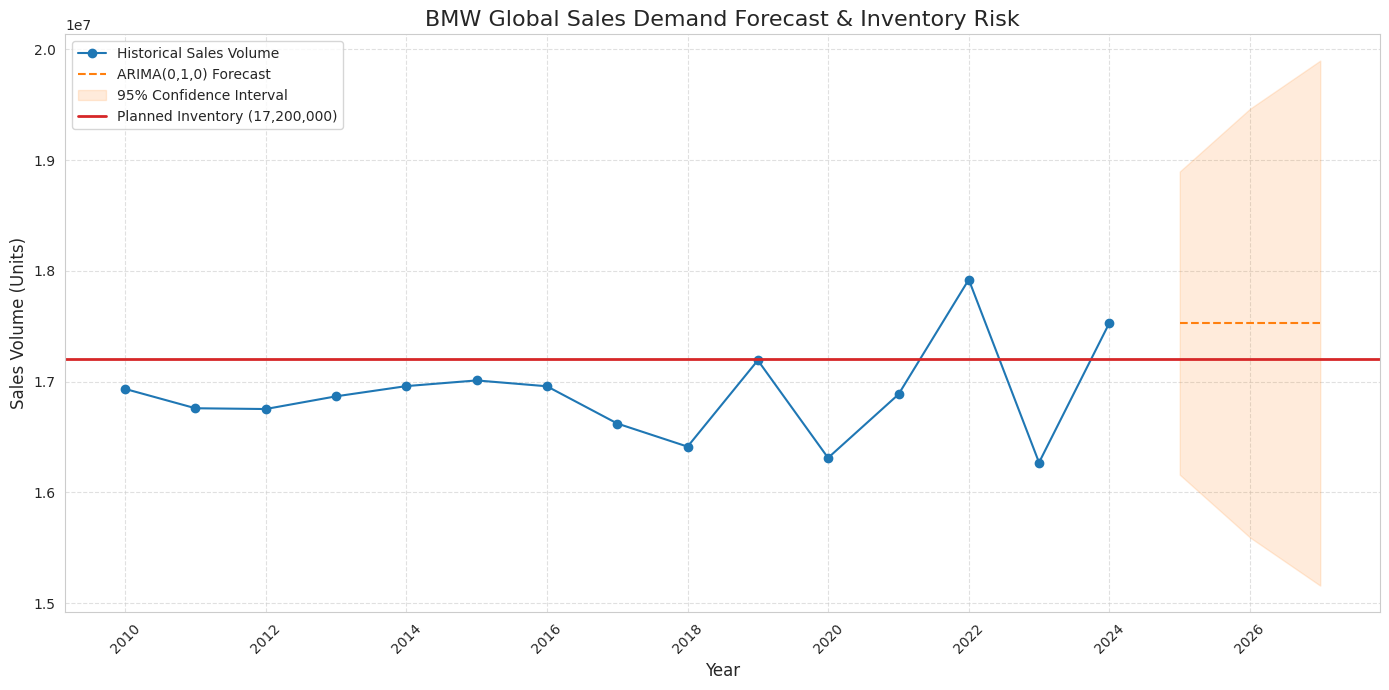

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure index is datetime for plotting
historical_data = time_series_data['Total_Sales_Volume']
forecast_data = inventory_report['Forecasted_Sales']

# Combine historical and forecasted index for a continuous plot
combined_index = historical_data.index.union(forecast_data.index)

# Create a full series for plotting the forecast line (starts where history ends)
forecast_plot_series = pd.Series(forecast_data, index=forecast_data.index)


plt.figure(figsize=(14, 7))

# 1. Plot Historical Data
plt.plot(historical_data.index, historical_data.values,
         label='Historical Sales Volume',
         color='tab:blue',
         marker='o')

# 2. Plot Forecasted Data (extending from history)
plt.plot(forecast_plot_series.index, forecast_plot_series.values,
         label='ARIMA(0,1,0) Forecast',
         color='tab:orange',
         linestyle='--')

# 3. Plot Confidence Interval (The Risk Band)
plt.fill_between(forecast_data.index,
                 inventory_report['Lower_CI'],
                 inventory_report['Upper_CI'],
                 color='tab:orange',
                 alpha=0.15,
                 label='95% Confidence Interval')

# 4. Plot Planned Inventory (The Risk Reference)
plt.axhline(y=inventory_report['Planned_Inventory'].iloc[0],
            color='tab:red',
            linestyle='-',
            linewidth=2,
            label=f"Planned Inventory ({inventory_report['Planned_Inventory'].iloc[0]:,})")


# Add titles, labels, and legend
plt.title('BMW Global Sales Demand Forecast & Inventory Risk', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Sales Volume (Units)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, which='major', linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Exporting Data to Google Sheets for Looker Studio

In [ ]:
import pandas as pd
from google.colab import files

# We need to prepare the DataFrame for download first:
export_df = inventory_report.copy()
export_df.reset_index(inplace=True)

# Rename the index column for clarity in the CSV
export_df.rename(columns={'index': 'Year'}, inplace=True)

# Format the Year column back to a simple string (YYYY)
export_df['Year'] = export_df['Year'].dt.strftime('%Y')

# Define the local filename
csv_filename = 'BMW_Inventory_Risk_Report.csv'

# Save the DataFrame to a CSV file in the Colab virtual machine
export_df.to_csv(csv_filename, index=False)

print(f"Download initiated for '{csv_filename}'")
print("Check your browser's download folder or the download manager on your iPad.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Download initiated for 'BMW_Inventory_Risk_Report.csv'
Check your browser's download folder or the download manager on your iPad.
